## Select GPU

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# DA RNN

## Imports

In [2]:
import matplotlib.pyplot as plt

from torch.autograd import Variable

import torch
import numpy as np
import pandas as pd
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
from torch.optim.lr_scheduler import ExponentialLR

from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

from prep_austin import austin_hourly

## Model Architecture

### Encoder

In [3]:
class Encoder(nn.Module):
    def __init__(self, T, input_size, encoder_num_hidden):
        super(Encoder, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.input_size = input_size
        self.T = T

        self.encoder_lstm = nn.LSTM(
            input_size=self.input_size,
            hidden_size=self.encoder_num_hidden,
            num_layers = 1
        )

        self.encoder_attn = nn.Linear(
            in_features=2 * self.encoder_num_hidden + self.T,
            out_features=1
        )

    def forward(self, X):
        X_tilde = X.new_zeros(X.size(0), self.T, self.input_size)
        X_encoded = X.new_zeros(X.size(0), self.T, self.encoder_num_hidden)

        h_n = self._init_states(X)
        s_n = self._init_states(X)

        for t in range(self.T):
            x = torch.cat((h_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           s_n.repeat(self.input_size, 1, 1).permute(1, 0, 2),
                           X.permute(0, 2, 1)), dim=2)
            
            x = self.encoder_attn(
                x.view(-1, self.encoder_num_hidden * 2 + self.T))

            alpha = F.softmax(x.view(-1, self.input_size), dim=1)
            x_tilde = torch.mul(alpha, X[:, t, :])
            self.encoder_lstm.flatten_parameters()

            _, final_state = self.encoder_lstm(x_tilde.unsqueeze(0), (h_n, s_n))
            h_n = final_state[0]
            s_n = final_state[1]

            X_tilde[:, t, :] = x_tilde
            X_encoded[:, t, :] = h_n

        return X_tilde, X_encoded

    def _init_states(self, X):
        return X.new_zeros(1, X.size(0), self.encoder_num_hidden)

### Decoder

In [4]:
class Decoder(nn.Module):
    def __init__(self, T, decoder_num_hidden, encoder_num_hidden):
        super(Decoder, self).__init__()
        self.decoder_num_hidden = decoder_num_hidden
        self.encoder_num_hidden = encoder_num_hidden
        self.T = T

        self.attn_layer = nn.Sequential(
            nn.Linear(2 * decoder_num_hidden + encoder_num_hidden, encoder_num_hidden),
            nn.Tanh(),
            nn.Linear(encoder_num_hidden, 1)
        )
        self.lstm_layer = nn.LSTM(
            input_size=1,
            hidden_size=decoder_num_hidden
        )
        self.fc = nn.Linear(encoder_num_hidden + 1, 1)
        self.fc_final = nn.Linear(decoder_num_hidden + encoder_num_hidden, 1)

        self.fc.weight.data.normal_()

    def forward(self, X_encoded, y_prev):
        d_n = self._init_states(X_encoded)
        c_n = self._init_states(X_encoded)

        for t in range(self.T):

            x = torch.cat((d_n.repeat(self.T, 1, 1).permute(1, 0, 2),
                           c_n.repeat(self.T, 1, 1).permute(1, 0, 2),
                           X_encoded), dim=2)

            beta = F.softmax(self.attn_layer(
                x.view(-1, 2 * self.decoder_num_hidden + self.encoder_num_hidden)).view(-1, self.T), dim=1)

            context = torch.bmm(beta.unsqueeze(1), X_encoded)[:, 0, :]
            if t < self.T:
                y_tilde = self.fc(
                    torch.cat((context, y_prev[:, t].unsqueeze(1)), dim=1))

                self.lstm_layer.flatten_parameters()
                _, final_states = self.lstm_layer(
                    y_tilde.unsqueeze(0), (d_n, c_n))

                d_n = final_states[0]
                c_n = final_states[1]

        y_pred = self.fc_final(torch.cat((d_n[0], context), dim=1))

        return y_pred

    def _init_states(self, X):
        return X.new_zeros(1, X.size(0), self.decoder_num_hidden)

### DA-RNN

In [5]:
class DA_rnn(nn.Module):
    def __init__(self, T,
                 encoder_num_hidden,
                 decoder_num_hidden,
                 input_size,
                 device = 'cpu',
                 parallel=False):
        super(DA_rnn, self).__init__()
        self.encoder_num_hidden = encoder_num_hidden
        self.decoder_num_hidden = decoder_num_hidden
        self.input_size = input_size
        self.parallel = parallel
        self.device = device
        self.T = T

        self.Encoder = Encoder(input_size=self.input_size,
                               encoder_num_hidden=encoder_num_hidden,
                               T=T).to(self.device)
        self.Decoder = Decoder(encoder_num_hidden=encoder_num_hidden,
                               decoder_num_hidden=decoder_num_hidden,
                               T=T).to(self.device)

        if self.parallel:
            self.encoder = nn.DataParallel(self.encoder)
            self.decoder = nn.DataParallel(self.decoder)

    def forward(self, t):
        X = t[:,:,:-1]
        y = t[:,:,-1]
        _ , input_encoded = self.Encoder(X.float().to(self.device))
        y_pred = self.Decoder(input_encoded, y.float().to(self.device))

        return y_pred

## Train and test loops

In [6]:
def train_loop(dataloader, model, loss_fn, encoder_optimizer, decoder_optimizer):
    size = len(dataloader.dataset)

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float().to(device))
        loss = loss_fn(pred, y.float().to(device))

        # Backpropagation
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    test_loss = 0
    sMAPE_values = np.empty((0,2))
    
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y.to(device)).item()
            sMAPE_values = np.concatenate((sMAPE_values, \
                np.column_stack((pred.cpu().detach().numpy().reshape(-1,1), y.numpy()))))
    
    sMAPE = np.array([abs(a-b)/(abs(a)+abs(b)) for (a,b) in sMAPE_values]).mean()*100
    
    test_loss /= num_batches
    print(f"Test results: \n sMAPE: {(sMAPE):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Util Function

In [7]:
def read_data(dataroot, train_prop, force_reload=False):
    df = austin_hourly(dataroot, force_reload)
    actual_targets = df['target'].to_numpy().reshape(-1,1)
    train_size = int(np.ceil(df.shape[0] * train_prop))
    train_df = df[:train_size]

    sc = MinMaxScaler()
    label_sc = MinMaxScaler()
    sc.fit(train_df)
    label_sc.fit(train_df['target'].values.reshape(-1,1))


    df = pd.DataFrame(
        sc.transform(df),
        index=df.index,
        columns=df.columns
    )

    inputs = []
    targets = []

    for i in range(T, len(df)):
        inputs.append(df[i-T:i].to_numpy())
        targets.append(df.loc[i, 'target'])

    inputs = np.array(inputs)
    targets = np.array(targets).reshape(-1,1)

    X_train = inputs[:train_size]
    y_train = targets[:train_size]

    X_test = inputs[train_size:]
    y_test = targets[train_size:]

    train_dataset = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
    test_dataset = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

    return train_dataset, test_dataset, actual_targets, label_sc

def plot_result():
    if epoch % 10 == 0:
        train_size = int(np.ceil(len(actual_targets) * train_prop))
        with torch.no_grad():
            preds = np.array([])
            for X, y in plot_dataloader:
                preds = np.concatenate((preds, model(X.to(device)).cpu().detach().numpy().reshape(-1)))
            preds = label_sc.inverse_transform(preds.reshape(-1,1))
            plt.ioff()
            plt.figure()
            plt.plot()
            plt.plot(actual_targets.reshape(-1), label="True")
            plt.plot(range(T, train_size + T),
                        preds[:train_size], label='Predicted - Train')
            plt.plot(range(T + train_size, len(actual_targets)),
                        preds[train_size:], label='Predicted - Test')
            plt.legend(loc='upper left')
            plt.show()


## Main

In [8]:
dataroot = '../data/residental_buildings'
batch_size = 128
nhidden_encoder = 128
nhidden_decoder = 128
T = 24
lr = 0.001
epochs = 50
shuffle = False
train_prop = 0.7

==> Load dataset ...
==> Use accelerator:  cuda
==> Initialize DA-RNN model ...
==> Start training ...
Epoch 1
Test results: 
 sMAPE: 34.9%, Avg loss: 0.007860 

Epoch 2
Test results: 
 sMAPE: 29.6%, Avg loss: 0.003606 

Epoch 3
Test results: 
 sMAPE: 23.3%, Avg loss: 0.003094 

Epoch 4
Test results: 
 sMAPE: 23.7%, Avg loss: 0.003022 

Epoch 5
Test results: 
 sMAPE: 23.8%, Avg loss: 0.002993 

Epoch 6
Test results: 
 sMAPE: 22.9%, Avg loss: 0.002998 

Epoch 7
Test results: 
 sMAPE: 22.5%, Avg loss: 0.002984 

Epoch 8
Test results: 
 sMAPE: 22.2%, Avg loss: 0.002998 

Epoch 9
Test results: 
 sMAPE: 22.4%, Avg loss: 0.003019 

Epoch 10
Test results: 
 sMAPE: 23.1%, Avg loss: 0.003041 



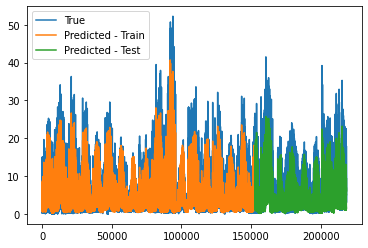

Epoch 11
Test results: 
 sMAPE: 26.6%, Avg loss: 0.003110 

Epoch 12
Test results: 
 sMAPE: 29.8%, Avg loss: 0.003108 

Epoch 13
Test results: 
 sMAPE: 32.4%, Avg loss: 0.003097 

Epoch 14
Test results: 
 sMAPE: 32.8%, Avg loss: 0.003051 

Epoch 15


In [9]:
# Read dataset
print("==> Load dataset ...")
train_dataset, test_dataset, actual_targets,label_sc = read_data(dataroot, train_prop)
input_size = train_dataset[0][0].shape[1]-1

# Create Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
plot_dataloader = DataLoader(ConcatDataset((train_dataset, test_dataset)), batch_size=batch_size, shuffle=False, drop_last=False)

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("==> Use accelerator: ", device)

# Initialize model
print("==> Initialize DA-RNN model ...")
model = DA_rnn(
    T,
    nhidden_encoder,
    nhidden_decoder,
    input_size,
    device
)

# Loss function
criterion = nn.MSELoss()

# Optimizer
encoder_optimizer = optim.Adam(model.Encoder.parameters(), lr=lr)
decoder_optimizer = optim.Adam(model.Decoder.parameters(), lr=lr)

scheduler1 = ExponentialLR(encoder_optimizer, gamma=0.9)
scheduler2 = ExponentialLR(decoder_optimizer, gamma=0.9)

# Train and Test
print("==> Start training ...")

for epoch in range(1,epochs+1):
    print(f"Epoch {epoch}")
    train_loop(train_dataloader, model, criterion, encoder_optimizer, decoder_optimizer)
    test_loop(test_dataloader, model, criterion)
    plot_result()

    # Update learning rate
    if epoch % 5 == 0:
        scheduler1.step()
        scheduler2.step  

print("Task done!")